In [1]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
# import csv
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [2]:
import operator as op
def nCr(n, r):
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom


In [3]:
# For scipy Linear Interpolation
def hs_rs_table(rate, blocklength):
    k = (1-rate)*blocklength
    msg = rate*blocklength
    op_SNR = arange(0, 5, 0.01)
    pbitdrop = array([0.5*math.erfc(sqrt(10**opsnr/2)) for opsnr in op_SNR])
    hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
    hcflst = 1 - (1-hcerr)**2
    reeddrop = [sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)]) \
                for hcf in hcflst]
#     func = interp1d(op_SNR, reeddrop, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    return [op_SNR, reeddrop]

In [4]:
def save_table(table, filename):
    f = open(filename, 'w')
    pickle.dump(table, f)
    f.close()
    
def load_table(filename):
    f = open(filename, 'r')
    table = pickle.load(f)
    f.close()
    return table

In [5]:
def shannon_combo(N, a, rate1, p1, SNR):
    rate2 = (N-a)/N*rate1 + 2*N/10000
    p2 = 1 - exp(-(2**rate2 -1)/(10**(SNR/10)))
    return p2**a * min(p2/p1, 1)

In [34]:
def adaptive_endpoints(fx, fade):
    grad = np.gradient(fx, 10**(-3))*10**(-3) # Magic
#     grad2 = np.gradient(grad, 10**(-4))*10**(-4)
    
    ind = argrelextrema(grad, np.less)[0]
    ind = ind[np.argsort(grad[ind])]
    if len(ind) > 0:
        mid = fade[ind[0]]
        end1, end2 = mid - 5000*10**(-9), mid + 5000*10**(-9) # Magic
    else:
        mid = 0
        end1, end2 = 0, 10**(-3)
    
    endpts = [end1, end2, 2]
    return endpts

In [40]:
# Adaptive
def p_single(codetable, op_SNR, endpoint, dfade, tabledSNR):
    fadexp = sp.stats.expon()
    fade = arange(0, endpoint, 10**(-3)) # Magic
    psingle = []
#     snrlookup = codetable(op_SNR+log10(fade))
#     fadepr = fadexp.pdf(fade)
    optimize = codetable(op_SNR+log10(fade)) * fadexp.pdf(fade)
    endpts = adaptive_endpoints(optimize, fade)
#     print(op_SNR, endpts)
#     dfade = [10**(-2), 10**(-5), 10**(-2)]
    fade = arange(0, endpts[0], dfade[0])
    fadepr = fadexp.pdf(fade)
    snrlookup = codetable(op_SNR+log10(fade))
    psingle.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        psingle.append(dfade[idx]*np.dot(snrlookup, fadepr))
    return sum(psingle)

In [8]:
def p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR):
    if a == 0:
        return 1.0
    fadexp = sp.stats.erlang(a)
    pcombo = []
    fade = arange(0, endpoint, 10**(-3))
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    optimize = snrlookup * fadepr
    endpts = adaptive_endpoints(optimize, fade)
    fade = arange(0, endpts[0], dfade[0])
    snrlookup = codetable(op_SNR+log10(fade))
    fadepr = fadexp.pdf(fade)
    pcombo.append(dfade[0]*np.dot(snrlookup, fadepr))
    for idx in range(1, len(endpts)):
        fade = arange(endpts[idx-1], endpts[idx], dfade[idx])
        snrlookup = codetable(op_SNR+log10(fade))
        fadepr = fadexp.pdf(fade)
        pcombo.append(dfade[idx]*np.dot(snrlookup, fadepr))
#         pcombo.append(sum([snr_lookup(codetable, kmin, kmax, op_SNR+log10(f), tabledSNR) * fadexp.pdf(f) * dfade[idx] for f in fade]))
    return sum(pcombo)

In [9]:
# N = num_nodes
def p_protocol(codetable, N, op_SNR, endpoint, dfade, tabledSNR):
    psingle = p_single(codetable, op_SNR, endpoint, dfade, tabledSNR)
#     print('psingle', psingle,| 'pcombo, ')
    return sum([nCr(N, a) * (1-psingle)**a * psingle**(N-a) * 
                (1-(1-p_combo(codetable, a, op_SNR, endpoint, dfade, tabledSNR))**(N-a)) for a in range(N)])

In [11]:
iterations = []

CPU times: user 4min 5s, sys: 20.3 s, total: 4min 25s
Wall time: 2min 23s


/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


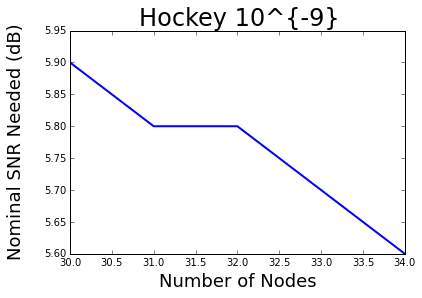

In [35]:
%%time
# Hockey Stick Plot Adaptive
nominal_needed = []
# shannon = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
# dSNR, dfade, end = 0.01, [10**(-4), 10**(-2)], [1, 2]
threshold = 10**(-9)
for N in range(30, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)
    
#     rate = N*160/10000
#     SNR = -10 # dB scale
#     pshannon = 1.0
#     while pshannon > threshold:
#         plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
#         pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
#                          (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
#         SNR += 0.01
#     shannon.append(SNR-0.01)


iterations.append(10*array(nominal_needed))
    
plot(range(30, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
# plot(range(2, 35), array(shannon), lw=2.0, label='Shannon')
# legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_test_9.pdf', bbox='tight')

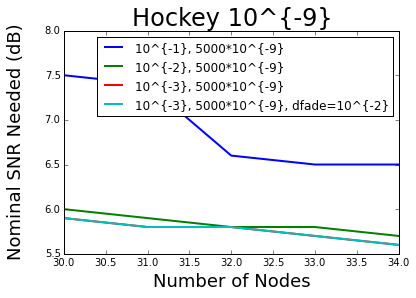

In [36]:
plot(range(30, 35), iterations[0], lw=2.0, label='10^{-1}, 5000*10^{-9}')
plot(range(30, 35), iterations[1], lw=2.0, label='10^{-2}, 5000*10^{-9}')
plot(range(30, 35), iterations[2], lw=2.0, label='10^{-3}, 5000*10^{-9}')
# plot(range(30, 35), iterations[3], lw=2.0, label='10^{-4}, 5000*10^{-9}')
# plot(range(30, 35), iterations[4], lw=2.0, label='10^{-3}, 10000*10^{-9}')
plot(range(30, 35), iterations[5], lw=2.0, label='10^{-3}, 5000*10^{-9}, dfade=10^{-2}')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)

In [30]:
print(iterations[1])
print(iterations[2])
print(iterations[3])
print(iterations[4])
print(iterations[5])

[ 6.   5.9  5.8  5.8  5.7]
[ 5.9  5.8  5.8  5.7  5.6]
[ 5.9  5.8  5.8  5.7  5.6]
[ 5.9  5.8  5.8  5.7  5.6]


In [37]:
iterations2 = []

/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/leahdickstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


CPU times: user 36min 59s, sys: 5min, total: 42min
Wall time: 1h 27min 32s


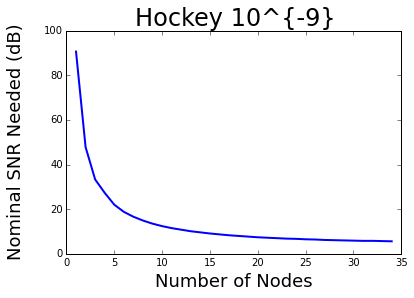

In [45]:
%%time
# Hockey Stick Plot Adaptive
nominal_needed = []
# shannon = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
# dSNR, dfade, end = 0.01, [10**(-4), 10**(-2)], [1, 2]
threshold = 10**(-9)
for N in range(1, 35):
    filename = 'lookup_0-01/n' + str(N) + '.in'
    codetable = load_table(filename)
    func = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    SNR = 0 # dB scale
    pprotocol = 1.0
    while pprotocol > threshold:
        pprotocol = p_protocol(func, N, SNR, end, dfade, dSNR)
        SNR += 0.01
#         print(SNR, pprotocol)
    nominal_needed.append(SNR-0.01)
    
    rate = N*160/10000
    SNR = -10 # dB scale
    pshannon = 1.0
    while pshannon > threshold:
        plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
        pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
                         (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
        SNR += 0.01
    shannon.append(SNR-0.01)


iterations2.append(10*array(nominal_needed))
    
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
# plot(range(2, 35), array(shannon), lw=2.0, label='Shannon')
# legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_ecc.pdf', bbox='tight')

In [44]:
print(iterations2[0])
print(iterations2[1])
print(iterations2[2])

[ 6.5  6.4  6.2  6.1  6.   5.9  5.8  5.8  5.7  5.6]
[ 6.5  6.4  6.2  6.1  6.   5.9  5.8  5.8  5.7  5.6]
[ 6.5  6.4  6.2  6.1  6.   5.9  5.8  5.8  5.7  5.6]


In [ ]:
plot(range(30, 35), iterations[0], lw=2.0, label='10^{-3}, 5000*10^{-9}, dfade=10^{-2}')
plot(range(30, 35), iterations[1], lw=2.0, label='10^{-3}, 5000*10^{-9}, dfade=10^{-3}')
plot(range(30, 35), iterations[1], lw=2.0, label='10^{-4}, 5000*10^{-9}, dfade=10^{-3}')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)

CPU times: user 5.28 s, sys: 92 ms, total: 5.37 s
Wall time: 5.71 s


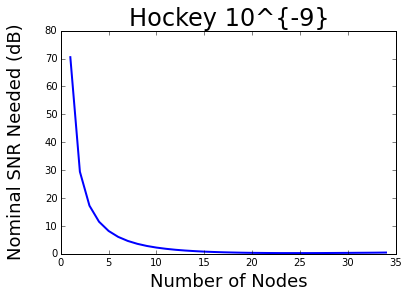

In [46]:
%%time
# Hockey Stick Plot Adaptive
# nominal_needed = []
shannon = []
dSNR = 0.01
dfade = [10**(-3), 10**(-10), 10**(-3)]
end = 2
# dSNR, dfade, end = 0.01, [10**(-4), 10**(-2)], [1, 2]
threshold = 10**(-9)
for N in range(1, 35):
    
    rate = N*160/10000
    SNR = -10 # dB scale
    pshannon = 1.0
    while pshannon > threshold:
        plink = 1 - exp(-(2**rate -1)/(10**(SNR/10)))
        pshannon = sum([nCr(N, a) * (1-plink)**a * plink**(N-a) * 
                         (1-(1-shannon_combo(N, a, rate, plink, SNR))**(N-a)) for a in range(N)])
        SNR += 0.01
    shannon.append(SNR-0.01)


iterations2.append(10*array(nominal_needed))
    
# plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
plot(range(1, 35), array(shannon), lw=2.0, label='Shannon')
# legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
# savefig('hockey_ecc.pdf', bbox='tight')

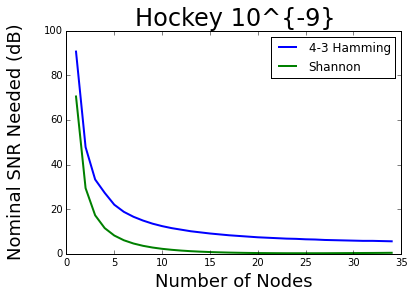

In [48]:
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
plot(range(1, 35), array(shannon), lw=2.0, label='Shannon')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_ecc.pdf', bbox='tight')

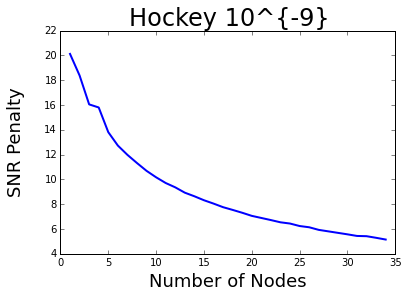

In [49]:
plot(range(1, 35), 10*array(nominal_needed)-array(shannon), lw=2.0, label='4-3 Hamming')
xlabel('Number of Nodes', fontsize=18)
ylabel('SNR Penalty', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)
savefig('hockey_ecc_penalty.pdf', bbox='tight')

In [54]:
def padd_snr(rate, target, rsblock, numwords):
#     param = 0.2*10**(-9)
#     rate = num_nodes*160/10000
    k = (1-rate)*rsblock
    
    pdbit = arange(0,0.15,0.001) # bit error prob
    hcerr = 1 - ((1-pdbit)**7 + 7*pdbit*(1-pdbit)**6)
    hammfail = 1 - (1-hcerr)**numwords

    for hcf in hammfail:
        reed = sum([nCr(rsblock, d)* hcf**d *(1-hcf)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
        if reed > target:
            break
    idx = np.where(hammfail==hcf)[0][0]
    hccrit = hammfail[idx-1]
    pbcrit = pdbit[idx-1]
    minSNR = (sqrt(2)*sp.special.erfinv(1-2*pbcrit))**2 #given bit drop prob min SNR needed to decode, 'Actual SNR'
    paddnoise = sum([nCr(rsblock, d)* hccrit**d *(1-hccrit)**(rsblock-d) for d in range(int(k/2)+1, rsblock)])
    return minSNR, paddnoise

# Loudest Talker

4-3 Hamming Code, 3 codewords put together form a Reed Solomon word

Threshold = $10^{-9}$  
P(Additive Noise) = $0.2 \cdot 10^{-9}$

P(bitdrop) = Range(0, 0.15, $10^{-3}$)  
Hamming "Syllable" Error = $1 - ((1-P(bitdrop))^7 + 7 \cdot P(bitdrop) \cdot (1-P(bitdrop))^6)$  
Hamming Codeword Failure = $1 - (1-hcerr)^3$  
$$ \text{P(Reed Solomon Code Failure)} = \sum_{d=\lfloor \frac{k}{2} \rfloor + 1}^{\text{block}} {\text{block} \choose d} \, hcf^d \, (1-hcf)^{\text{block}-d} = \text{P(Additive Noise)}$$
P(Additive Noise) $\rightarrow$ P(Critical bitdrop) $\rightarrow$ Actual SNR Needed

$$ \text{P(bad fade)} = 1 - \text{exp} \left( \frac{-\text{Actual SNR}}{\text{Nominal SNR}} \right) $$
P(Protocol) = $10^{-9} \rightarrow$ Nominal SNR

CPU times: user 42.3 s, sys: 489 ms, total: 42.8 s
Wall time: 43.4 s


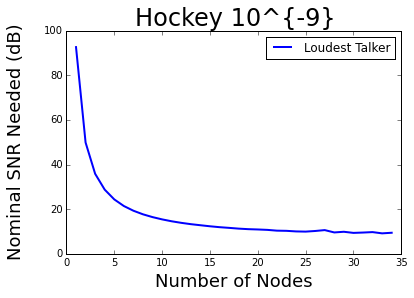

In [60]:
%%time
numwords = 3 # number of hamming code blocks stuck together
bpw = 21 # bits per word

target = 10**(-9)
msgsize = 160
blocklength = 10000
rsblock = int(blocklength/bpw)

nomSNR = []
padd = []
nomtracker = []
# actual = []

for N in range(1, 35):
    rate = N*msgsize/blocklength
    ratio = 0.2
    actualSNR, paddnoise = padd_snr(rate, ratio*target, rsblock, numwords)
    padd.append(paddnoise)
    
    SNR = 0
    pprotocol = 1.0
    while pprotocol > target:
        SNR += 0.01
        pbadfade = 1 - math.exp(-actualSNR/10**(SNR/10))
        pnom = pbadfade + paddnoise # p nominal
        pprotocol = sum([nCr(N, a) * (1-pnom)**a * pnom**(N-a) * (1-(1-pbadfade**a-paddnoise)**(N-a)) for a in range(N)])
        
    nomSNR.append(SNR)
    nomtracker.append(pnom)
    
plot(range(1, 35), nomSNR, lw=2.0, label='Loudest Talker')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=20)
title('Hockey 10^{-9}', fontsize=24)

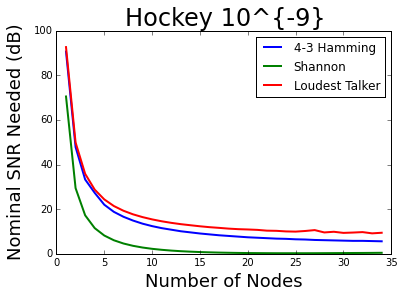

In [64]:
plot(range(1, 35), 10*array(nominal_needed), lw=2.0, label='4-3 Hamming')
plot(range(1, 35), array(shannon), lw=2.0, label='Shannon')
plot(range(1, 35), nomSNR, lw=2.0, label='Loudest Talker')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Nominal SNR Needed (dB)', fontsize=18, labelpad=10)
title('Hockey 10^{-9}', fontsize=24)
# savefig('hockey_9.pdf', bbox='tight')